#Import and install modules

In [1]:
!pip install hazm

  Using cached https://files.pythonhosted.org/packages/22/13/5a7074bc11d20dbbb46239349ac3f85f7edc148b4cf68e9b8c2f8263830c/hazm-0.7.0-py3-none-any.whl
Processing /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c/nltk-3.3-cp36-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/0f/1c9b49bb49821b5856a64ea6fac8d96a619b9f291d1f06999ea98a32c89c/libwapiti-0.2.1.tar.gz
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp36-cp36m-linux_x86_64.whl size=154767 sha256=8363b16fb6feda25b46f2347966aebff98a4b1d5292d6ac40ef01d48ad07f6b7
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
import re
import hazm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse, stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix

#Load and tag data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/emails")
!ls

Mounted at /content/drive
hamtesting  hamtraining  spamtesting  spamtraining


In [4]:
def read_folder(name, size):
  items = []
  for i in range(1, size + 1):
    address = name + '/' + name + ' (' + str(i) + ').txt'
    with open(address, 'r', encoding='utf-8') as txt_file:
      items.append(txt_file.read())
  return items

ham_test = read_folder('hamtesting', 200)
ham_train = read_folder('hamtraining', 300)
spam_test = read_folder('spamtesting', 200)
spam_train = read_folder('spamtraining', 300)

In [5]:
ham_test[:3]

['\ufeffممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نکرده بودم و سراسری هم قبول نشدم. فقط میخواستم بدونم شرایط چطوریه واسه سال بعد. مرسی از راهنمایی هاتون.',
 '\ufeffدوست عزیز آقای سعیدی، کتاب حاضر را چندی پیش به سفارش یکی از مجلات قرار بود که نقدی بکنم، وقتی کتاب را مطالعه کردم، چون مشغله زیادی داشتم به یکی از دوستان دادم که نقد و معرفی از آن به رشته تحریر درآورد، و به نام خودش آن را نیز چاپ کند. دکتر دادور را نیز از طریق یکی از دانشجویانش شناختم.\nبا آن\u200cکه دکتر دادور در فرانسه دانی استاد خوبیست، اما کتاب فرهنگ نشانه-معناشناختی کتاب ضعیفی است. هم از نظر انتخاب معادل برای اصطلاحات نشانه\u200cشناسی و معناشناسی یا زبان\u200cشناسی، و هم از نظر ارائه اطلاعات فرهنگ\u200cنگاری. متاسفانه آن دوست ما خلف وعده کرد و نقد خود را ننوشت، و کاهلی کرد. اگر زمانی فرصت کنم شاید نقدی بر آن بنویسم. اگر خداوند عمری دهد. یا حق یا هو.',
 '\ufeffسلام خیلی عالی بود ممکنه اگه مقاله دیگه ای از دکتر باطنی دارید برام ایمل کنید ممنون می شم دانشجوی ارشد ادبیاتم برای تحقیق دستور بهشون احتیاج دارم . ممنون']

In [6]:
def tagging(items, tag):
  tagged_items = []
  for item in items:
    tagged_items.append([item, tag])
  return tagged_items

ham_test = tagging(ham_test, 'ham')
ham_train = tagging(ham_train, 'ham')
spam_test = tagging(spam_test, 'spam')
spam_train = tagging(spam_train, 'spam')

In [7]:
ham_test[:3]

[['\ufeffممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نکرده بودم و سراسری هم قبول نشدم. فقط میخواستم بدونم شرایط چطوریه واسه سال بعد. مرسی از راهنمایی هاتون.',
  'ham'],
 ['\ufeffدوست عزیز آقای سعیدی، کتاب حاضر را چندی پیش به سفارش یکی از مجلات قرار بود که نقدی بکنم، وقتی کتاب را مطالعه کردم، چون مشغله زیادی داشتم به یکی از دوستان دادم که نقد و معرفی از آن به رشته تحریر درآورد، و به نام خودش آن را نیز چاپ کند. دکتر دادور را نیز از طریق یکی از دانشجویانش شناختم.\nبا آن\u200cکه دکتر دادور در فرانسه دانی استاد خوبیست، اما کتاب فرهنگ نشانه-معناشناختی کتاب ضعیفی است. هم از نظر انتخاب معادل برای اصطلاحات نشانه\u200cشناسی و معناشناسی یا زبان\u200cشناسی، و هم از نظر ارائه اطلاعات فرهنگ\u200cنگاری. متاسفانه آن دوست ما خلف وعده کرد و نقد خود را ننوشت، و کاهلی کرد. اگر زمانی فرصت کنم شاید نقدی بر آن بنویسم. اگر خداوند عمری دهد. یا حق یا هو.',
  'ham'],
 ['\ufeffسلام خیلی عالی بود ممکنه اگه مقاله دیگه ای از دکتر باطنی دارید برام ایمل کنید ممنون می شم دانشجوی ارشد ادبیاتم برای تحقیق دستور بهشون احتیا

In [8]:
train_set = pd.DataFrame(ham_train + spam_train, columns=['text', 'tag'])
test_set = pd.DataFrame(ham_test + spam_test, columns=['text', 'tag'])

# shuffle data
train_set = train_set.sample(frac = 1)
train_set.reset_index(drop=True, inplace=True)
test_set = test_set.sample(frac = 1)
test_set.reset_index(drop=True, inplace=True)

In [9]:
train_set.head()

,text,tag
0,﻿\n*\n\n \n\n<http://www.payegan.ir/one.htm>\n...,spam
1,﻿ عباس جانم !\nباز هم ممنونم\nاگر طبق قرار امک...,ham
2,﻿سلام. البته فکر کنم قبلا گفته بودم و الان دوب...,ham
3,﻿\t\nبا سلام این جانب رضا ناصری دارای مدرک کار...,ham
4,﻿معصومه خانم:\nخیلی خیلی ممنون. نیازی نیست که ...,ham


#Preprocess

##Normalizing the text

In [10]:
def normalize(text):
  text = text.replace(to_replace =r"[ئيی]", value = 'ی', regex = True)
  text = text.replace(to_replace =r"[ك]", value = 'ک', regex = True)
  text = text.replace(to_replace =r"[ؤ]", value = 'و', regex = True)
  text = text.replace(to_replace =r"[ة]", value = 'ه', regex = True)
  text = text.replace(to_replace =r"[أإ]", value = 'ا', regex = True)
  text = text.replace(to_replace =r"[^ضصثقفغعهخحجچشسیبلاآتنمکگظطزژرذدپو]", value = ' ', regex = True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  

In [11]:
train_set.text = normalize(train_set.text)
test_set.text = normalize(test_set.text)

train_set.head()

,text,tag
0,ثبت در یک هفته هزینه چند صد هزار تومان فروش ح...,spam
1,عباس جانم باز هم ممنونم اگر طبق قرار امکان خر...,ham
2,سلام البته فکر کنم قبلا گفته بودم و الان دوبا...,ham
3,با سلام این جانب رضا ناصری دارای مدرک کارشناس...,ham
4,معصومه خانم خیلی خیلی ممنون نیازی نیست که این...,ham


##Word Tokenizing

In [12]:
def tokenizer(text):
  text = text.str.split(' ')
  return text
  
train_set.text = tokenizer(train_set.text)
test_set.text = tokenizer(test_set.text)

train_set.head()

,text,tag
0,"[, ثبت, در, یک, هفته, هزینه, چند, صد, هزار, تو...",spam
1,"[, عباس, جانم, باز, هم, ممنونم, اگر, طبق, قرار...",ham
2,"[, سلام, البته, فکر, کنم, قبلا, گفته, بودم, و,...",ham
3,"[, با, سلام, این, جانب, رضا, ناصری, دارای, مدر...",ham
4,"[, معصومه, خانم, خیلی, خیلی, ممنون, نیازی, نیس...",ham


##Stem and Lemma and stopwords

In [13]:
def SS(stemmer, lemmatizer, stopwords, alphabet, tokens):
  final_tokens = []
  for token in tokens:
    stemmed_token = stemmer.stem(lemmatizer.lemmatize(token))
    if '#' in stemmed_token:
      stemmed_token = stemmed_token.split('#')[0]
    if token not in stopwords and stemmed_token not in stopwords and not token == '' and stemmed_token not in alphabet:
      final_tokens.append(stemmed_token)
  return final_tokens


stemmer = hazm.Stemmer()
lemmatizer = hazm.Lemmatizer()
stopwords = hazm.stopwords_list()
alphabet = set(list('آابپتثجچحخدذرزژسشصضطظعغفقکگلم‌ن‌وهی'))

train_set.text = train_set.apply(lambda row: SS(stemmer, lemmatizer, stopwords, alphabet, row.text), axis=1)
test_set.text = test_set.apply(lambda row: SS(stemmer, lemmatizer, stopwords, alphabet, row.text), axis=1)

train_set.head()

,text,tag
0,"[ثب, هفته, هزینه, صد, هزار, فرو, میلون, سود, ک...",spam
1,"[عباس, ممنون, قرار, خریدار, کتاب, طریق, سا, گر...",ham
2,"[سلا, قبلا, ال, بگ, هزینه, دکتر, آزاد, سال, قب...",ham
3,"[سلا, جانب, رضا, ناصر, مدرک, کارشناس, مکانیک, ...",ham
4,"[معصومه, خان, ممنون, قدر, تعریف, وظیف, انجا, م...",ham


##Information about words in data

In [14]:
def num_words(words):
  return len(words)

train_set['words_num'] = train_set.apply(lambda row: num_words(row.text), axis=1)
test_set['words_num'] = test_set.apply(lambda row: num_words(row.text), axis=1)

def num_distinct_words(words):
  return len(set(words))

train_set['distinct_words_num'] = train_set.apply(lambda row: num_distinct_words(row.text), axis=1)
test_set['distinct_words_num'] = test_set.apply(lambda row: num_distinct_words(row.text), axis=1)

train_set.head()

,text,tag,words_num,distinct_words_num
0,"[ثب, هفته, هزینه, صد, هزار, فرو, میلون, سود, ک...",spam,232,131
1,"[عباس, ممنون, قرار, خریدار, کتاب, طریق, سا, گر...",ham,31,28
2,"[سلا, قبلا, ال, بگ, هزینه, دکتر, آزاد, سال, قب...",ham,109,61
3,"[سلا, جانب, رضا, ناصر, مدرک, کارشناس, مکانیک, ...",ham,24,24
4,"[معصومه, خان, ممنون, قدر, تعریف, وظیف, انجا, م...",ham,105,73


In [15]:
def all_words(data):
  words = set()
  for text in data.text:
    for word in text:
      words.add(word)
  return words

train_words = all_words(train_set)
test_words = all_words(test_set)

print('train set = all words: ', sum(train_set.words_num), ' and distinct words: ', len(train_words))
print('test set = all words: ', sum(test_set.words_num), ' and distinct words: ', len(test_words))

train set = all words:  96557  and distinct words:  9206
test set = all words:  61127  and distinct words:  7753


##Dev data extraction

In [16]:
train_set.shape

(600, 4)

In [17]:
test_set.shape

(400, 4)

=> train_data = 600, test_data = 200, dev_data = 200

In [18]:
dev_set = test_set[:200]
test_set = test_set[200:]

# data was shuffeled before

#Vectorizer

In [19]:
class TfIdf:
  def __init__(self, words):
    self.words = words
    self.w2i = {word: idx for idx, word in enumerate(self.words)}

  def fit_transform(self, data_set):
    self.df = {}
    for text in data_set:
      distinct_words = set(text)
      for word in distinct_words:
        if word not in self.df:
          self.df[word] = 0
        self.df[word] += 1
    return self.transform(data_set)

  def transform(self, data_set):
    row = []
    col = []
    vectorized_data = []
    data_size = len(data_set)
    
    for idx, text in enumerate(data_set):
      word_freq = {}
      for word in text:
        if word in self.words:
          if word not in word_freq:
            word_freq[word] = 0
          word_freq[word] += 1
      for word in word_freq.keys():
        row.append(idx)
        col.append(self.w2i[word])
        tfidf = (int(((np.log10(word_freq[word]) + 1) * (np.log10(data_size / self.df[word]))) * 100)) / 100
        vectorized_data.append(tfidf)

    return sparse.csr_matrix((vectorized_data, (row, col)), shape=(data_size, len(self.words)))

  def get_feature_names(self):
    return self.w2i.keys()

#Feature Extraction

In [20]:
X_train = train_set.text.to_list()
y_train = train_set.tag.to_list()
X_test = test_set.text.to_list()
y_test = test_set.tag.to_list()
X_dev = dev_set.text.to_list()
y_dev = dev_set.tag.to_list()

vectorize

In [21]:
vectorizer = TfIdf(train_words)
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()
X_dev_vectorized = vectorizer.transform(X_dev).toarray()

In [22]:
X_train_vectorized.shape

(600, 9206)

In [23]:
X_train_vectorized

array([[0.13, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.08, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.21, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.13, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [24]:
X_test_vectorized.shape

(200, 9206)

In [25]:
X_dev_vectorized.shape

(200, 9206)

Applying Chi2

k = 500

In [26]:
transformer_500 = SelectKBest(chi2, k=500).fit(X_train_vectorized, y_train)
X_train_vectorized_500 = transformer_500.transform(X_train_vectorized)
X_test_vectorized_500 = transformer_500.transform(X_test_vectorized)
X_dev_vectorized_500 = transformer_500.transform(X_dev_vectorized)

In [27]:
X_train_vectorized_500.shape

(600, 500)

In [28]:
X_test_vectorized_500.shape

(200, 500)

In [29]:
X_dev_vectorized_500.shape

(200, 500)

k = 200

In [30]:
transformer_200 = SelectKBest(chi2, k=200).fit(X_train_vectorized, y_train)
X_train_vectorized_200 = transformer_200.transform(X_train_vectorized)
X_test_vectorized_200 = transformer_200.transform(X_test_vectorized)
X_dev_vectorized_200 = transformer_200.transform(X_dev_vectorized)

In [31]:
X_train_vectorized_200.shape

(600, 200)

In [32]:
X_test_vectorized_200.shape

(200, 200)

In [33]:
X_dev_vectorized_200.shape

(200, 200)

Text(0.5, 0, '$\\chi^2$')

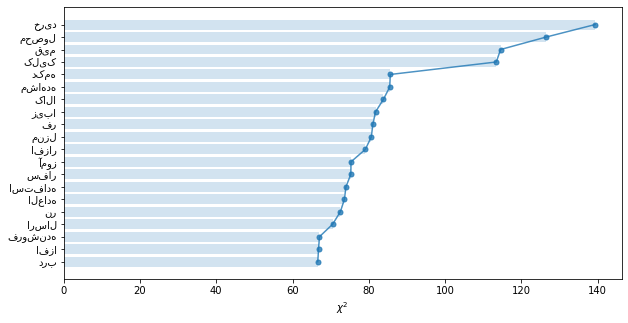

In [34]:
# plot the most important words identified by chi2

chi2score = chi2(X_train_vectorized, y_train)[0]
plt.figure(figsize=(10,5))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

#Naive Bayse

In [35]:
class NaiveBayes:
  def fit(self, X, y, words):
    self.words = words
    self.tags = set(y)
    self.tag_probs = {tag: y.count(tag) / len(y) for tag in self.tags}
    self.word_tag_freq = {tag: {} for tag in self.tags}

    for text, tag in zip(X, y):
      for word in text:
        if word not in self.word_tag_freq[tag]:
          self.word_tag_freq[tag][word] = 0
        self.word_tag_freq[tag][word] += 1

  def predict(self, X):
    predicted_tags = []
    probs = {tag: 0 for tag in self.tags}
    for text in X:
      for tag in self.tags:
        probs[tag] = np.log10(self.tag_probs[tag])
        for word in text:
          word_freq = 0
          if word in self.word_tag_freq[tag]:
            word_freq = self.word_tag_freq[tag][word]
        probs[tag] += np.log10((word_freq + 1) / (sum(self.word_tag_freq[tag].values()) + len(self.words)))
      predicted_tags.append(max(probs, key=probs.get))

    return predicted_tags

#KNN

In [44]:
class KNN:
  def __init__(self, k):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X_test, similarity_type = 'cosin'):
    predicted_tags = []

    if similarity_type == 'cosin':
      similarities = cosine_similarity(X_test, self.X_train)
      for idx in range(len(similarities)):
        nearests = np.argsort(similarities[idx])[::-1][:self.k]
        nearest_tags = [self.y_train[near] for near in nearests]
        predicted_tags.append(stats.mode(nearest_tags)[0])
    else:
      distances = self.tfidf_distance(X_test, self.X_train)
      for idx in range(len(distances)):
        nearests = np.argsort(distances[idx])[:self.k]
        nearest_tags = [self.y_train[near] for near in nearests]
        predicted_tags.append(stats.mode(nearest_tags)[0])

    return predicted_tags

  def tfidf_distance(self, X_test, X_train):
    train_tfidf = [(sum([tfidf for tfidf in text])) for text in X_train]
    test_tfidf = [(sum([tfidf for tfidf in text])) for text in X_test]
    distances = [[(abs(test - train)) for train in train_tfidf] for test in test_tfidf]
    return distances


#Train

##KNN

In [45]:
def explore(X_train, y_train, X_dev, y_dev):
  for k in range(3, 11, 2):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    #cosin similarity
    knn_predictions = knn.predict(X_dev)
    print("برای ", k, " همسایه ", "و شباهت کوسینوسی: ")
    print(classification_report(y_dev, knn_predictions))
    #tfidf similarity
    knn_predictions = knn.predict(X_dev, similarity_type = 'tfidf')
    print("برای ", k, " همسایه ", "و شباهت غیرکوسینوسی: ")
    print(classification_report(y_dev, knn_predictions))


###KNN - with out chi2

In [46]:
explore(X_train_vectorized, y_train, X_dev_vectorized, y_dev)

برای  3  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.94      0.93      0.94       102
        spam       0.93      0.94      0.93        98

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200

برای  3  همسایه  و شباهت غیرکوسینوسی: 
              precision    recall  f1-score   support

         ham       0.56      0.66      0.60       102
        spam       0.56      0.46      0.51        98

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.56      0.56      0.56       200

برای  5  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.93      0.95      0.94       102
        spam       0.95      0.93      0.94        98

    accuracy                           0.94       200
   macro avg     

 مقایسه نتایج بالا با توجه به هدف و اهمیت هر معیار میتواند متفاوت باشد. ولی بطور کلی با ۷ همسایه و شباهت کسینوسی نتایج نسبتا بهتری گرفته ایم.

In [47]:
knn = KNN(7)
knn.fit(X_train_vectorized, y_train)

###KNN - chi2(k=500)

In [48]:
explore(X_train_vectorized_500, y_train, X_dev_vectorized_500, y_dev)

برای  3  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.88      0.97      0.93       102
        spam       0.97      0.87      0.91        98

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

برای  3  همسایه  و شباهت غیرکوسینوسی: 
              precision    recall  f1-score   support

         ham       0.63      0.92      0.75       102
        spam       0.84      0.43      0.57        98

    accuracy                           0.68       200
   macro avg       0.73      0.68      0.66       200
weighted avg       0.73      0.68      0.66       200

برای  5  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.88      0.97      0.93       102
        spam       0.97      0.87      0.91        98

    accuracy                           0.92       200
   macro avg     

 مقایسه نتایج بالا با توجه به هدف و اهمیت هر معیار میتواند متفاوت باشد. ولی بطور کلی با ۳ همسایه و شباهت کسینوسی نتایج نسبتا بهتری گرفته ایم.

In [49]:
knn_500 = KNN(3)
knn_500.fit(X_train_vectorized_500, y_train)

###KNN - chi2(k=200)

In [50]:
explore(X_train_vectorized_200, y_train, X_dev_vectorized_200, y_dev)

برای  3  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.87      0.98      0.92       102
        spam       0.98      0.85      0.91        98

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

برای  3  همسایه  و شباهت غیرکوسینوسی: 
              precision    recall  f1-score   support

         ham       0.62      0.99      0.76       102
        spam       0.97      0.37      0.53        98

    accuracy                           0.69       200
   macro avg       0.80      0.68      0.65       200
weighted avg       0.79      0.69      0.65       200

برای  5  همسایه  و شباهت کوسینوسی: 
              precision    recall  f1-score   support

         ham       0.88      0.96      0.92       102
        spam       0.96      0.87      0.91        98

    accuracy                           0.92       200
   macro avg     

 مقایسه نتایج بالا با توجه به هدف و اهمیت هر معیار میتواند متفاوت باشد. ولی بطور کلی با ۷ همسایه و شباهت کسینوسی نتایج نسبتا بهتری گرفته ایم.

In [51]:
knn_200 = KNN(7)
knn_200.fit(X_train_vectorized_200, y_train)

##NaiveBayes

In [52]:
naivebayes = NaiveBayes()
naivebayes.fit(X_train, y_train, train_words)
naivebayes_predictions = naivebayes.predict(X_dev)
print(classification_report(y_dev, naivebayes_predictions))

              precision    recall  f1-score   support

         ham       0.72      0.75      0.73       102
        spam       0.72      0.69      0.71        98

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



#Evaluate

##plot confusion matrix

In [53]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_test))-0.5)
    plt.ylim(len(np.unique(y_test))-0.5, -0.5)
    return ax

##KNN - with out chi2

In [54]:
    knn_predictions = knn.predict(X_test_vectorized)
    print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

         ham       0.96      0.97      0.96        98
        spam       0.97      0.96      0.97       102

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



Confusion matrix, without normalization
[[95  3]
 [ 4 98]]


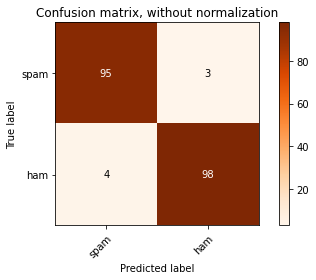

In [55]:
plot_confusion_matrix(y_test, knn_predictions, ['spam', 'ham'])

##KNN - chi2(k=500)

In [56]:
    knn_predictions = knn_500.predict(X_test_vectorized_500)
    print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

         ham       0.93      0.96      0.94        98
        spam       0.96      0.93      0.95       102

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200



Confusion matrix, without normalization
[[94  4]
 [ 7 95]]


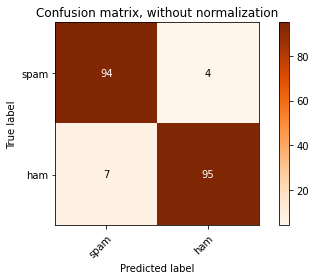

In [57]:
plot_confusion_matrix(y_test, knn_predictions, ['spam', 'ham'])

##KNN - chi2(k=200)

In [58]:
    knn_predictions = knn_200.predict(X_test_vectorized_200)
    print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

         ham       0.95      0.91      0.93        98
        spam       0.92      0.95      0.93       102

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



Confusion matrix, without normalization
[[89  9]
 [ 5 97]]


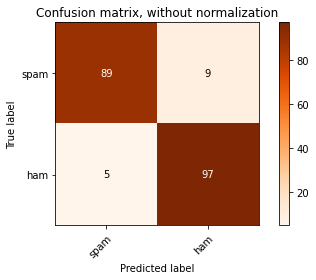

In [59]:
plot_confusion_matrix(y_test, knn_predictions, ['spam', 'ham'])

##NaiveBayes

In [60]:
naivebayes_predictions = naivebayes.predict(X_test)
print(classification_report(y_test, naivebayes_predictions))

              precision    recall  f1-score   support

         ham       0.62      0.74      0.68        98
        spam       0.70      0.57      0.63       102

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



Confusion matrix, without normalization
[[73 25]
 [44 58]]


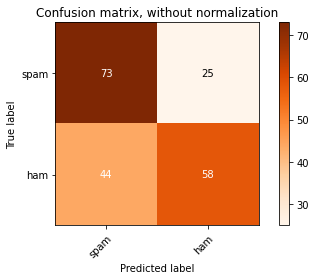

In [61]:
plot_confusion_matrix(y_test, naivebayes_predictions, ['spam', 'ham'])